In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

from scipy.cluster.vq import vq, kmeans2, whiten

In [2]:
def run_cem(cem_iter_func, f, d, p, N, total_iter, cutoff=50):
    mu, sigma = np.random.normal(size=[2])*5, np.ones([2])
    intermeds = []
    for t in range(total_iter):
        if len(sigma.shape)==1:
            intermeds.append((mu, sigma))
        else:
            intermeds.append((mu, np.diag(sigma)))
        mu, sigma = cem_iter_func(f, d, p, N, mu, sigma, t, total_iter)
        if np.any(mu > cutoff):
            break
    return mu, intermeds
        

In [3]:
def test_cem(cem_iter_func, f, d, p, N, minima, eps=1e-1, total_iter=1000, cutoff=50, num_tests=30):
    iter_num = []
    for _ in range(num_tests):
        mu, sigma = np.random.normal(size=[2])*5, np.ones([2])
        intermeds = []
        for t in range(total_iter):
            if len(sigma.shape)==1:
                intermeds.append((mu, sigma))
            else:
                intermeds.append((mu, np.diag(sigma)))
            mu, sigma = cem_iter_func(f, d, p, N, mu, sigma, t, total_iter)
            if np.any(mu > cutoff):
                iter_num.append(total_iter)
                break
            if np.sqrt(np.sum((mu-minima)**2))<eps:
                iter_num.append(t)
                break
    mean_num_iter = np.mean(iter_num)
    freq_success = np.sum(np.array(iter_num) < total_iter)/num_tests
    return mean_num_iter, freq_success

In [4]:
std_proj = np.eye(2)
def plot_intermeds(intermeds, f=None, minima=None, proj=std_proj, x_lim=(-20,20), y_lim=(-20,20)):
    fig, ax = plt.subplots()
    # contour plot f
    if f is not None:
        pass
        ngridx = 100
        ngridy = 100
        xi = np.linspace(x_lim[0], x_lim[1], ngridx)
        yi = np.linspace(y_lim[0], y_lim[1], ngridy)
        Xi, Yi = np.meshgrid(xi, yi)
        zi = f(np.stack([Xi.flatten(), Yi.flatten()], axis=1)).reshape(Xi.shape)
        levels = np.linspace(np.min(zi),np.max(zi),7)
#         ax.contour(xi, yi, zi, levels=levels)
        ax.contourf(xi, yi, zi, levels=levels, cmap='Reds')
    
    if minima is not None:
        norm_min = np.array(minima).flatten()
        ax.scatter([norm_min[0]], [norm_min[1]], color="green")
    
    patches = []
    for pos, std in intermeds:
        pos = pos.dot(proj)
        std = std.dot(proj)
        ellipse = mpatches.Ellipse(pos, std[0], std[1])
        patches.append(ellipse)
    collection = PatchCollection(patches)
    # collection.set_array(np.array(colors))
    ax.add_collection(collection)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    plt.show()

In [5]:
def cem_iter(f, d, p, N, mu, sigma, *args, **kwargs):
    X = np.random.normal(size=[N, d])*sigma + mu
    Y = f(X)
    X_sorted = X[Y.argsort(), :]
    num_elite = int(N*p)
    Elite = X_sorted[-num_elite:]
    mu, sigma = np.mean(Elite, axis=0), np.std(Elite, axis=0)
    return mu, sigma

In [6]:
def noisy_cem_iter(f, d, p, N, mu, sigma, t, total_iter, *args, **kwargs):
    X = np.random.normal(size=[N, d])*sigma + mu
    Y = f(X)
    X_sorted = X[Y.argsort(), :]
    num_elite = int(N*p)
    Elite = X_sorted[-num_elite:]
    mu = np.mean(Elite, axis=0)
    s_t = 1-t/total_iter
    sigma_2 = np.mean((Elite - mu[np.newaxis,:])**2+s_t**2, axis=0)
    sigma = np.sqrt(sigma_2)
    return mu, sigma

In [7]:
def cem_cauchy_iter(f, d, p, N, mu, sigma, *args, **kwargs):
    X = np.random.standard_cauchy(size=[N, d])*sigma + mu
    Y = f(X)
    X_sorted = X[Y.argsort(), :]
    num_elite = int(N*p)
    Elite = X_sorted[-num_elite:]
    mu, sigma = np.mean(Elite, axis=0), np.std(Elite, axis=0)
    return mu, sigma

In [8]:
def cem_modal_iter(f, d, p, N, mu, sigma, *args, **kwargs):
    X = np.random.standard_cauchy(size=[N, d])*sigma + mu
    Y = f(X)
    X_sorted = X[Y.argsort(), :]
    num_elite = int(N*p)
    Elite = X_sorted[-num_elite:]
    k_clus, labels = kmeans2(Elite,5)
    k_clus_Y = f(k_clus)
    top_i = k_clus_Y.argsort()[-1]
    top_choice = k_clus[top_i ,:]
    elite_k = Elite[labels==top_i]
    mu = top_choice
    sigma = np.std(elite_k, axis=0)
    return mu, sigma

In [9]:
def noisy_cem_no_diag_iter(f, d, p, N, mu, sigma, t, total_iter, *args, **kwargs):
    sigma = np.array(sigma)
    if len(sigma.shape)==1:
        cov = np.diag(sigma)
    else:
        cov = sigma
    X = np.random.multivariate_normal(mu, cov, size=N)
    Y = f(X)
    X_sorted = X[Y.argsort(), :]
    num_elite = int(N*p)
    Elite = X_sorted[-num_elite:]
    mu = np.mean(Elite, axis=0)
    s_t = 1-t/total_iter
    cov = np.cov((Elite-mu[np.newaxis,:]).T) + s_t**2
    return mu, cov

In [10]:
def f1(X):
    return np.minimum(X[...,0], 20-X[...,0])
d1 = 2
minima1=(10,0)

In [11]:
A0 = np.random.normal(size=[2,2])
A = A0.dot(A0.T)
B = np.random.normal(size=[1,2])*5
def f2(X, A=A, B=B):
    XB= X-B
    Y = -np.einsum("ij,jk,ik->i", XB,A,XB)
    return Y
minima2 = B
d2 = 2

In [12]:
def f3(X, a=1, b=100):
    x = X[...,0]
    y = X[...,1]
    return -((a-x)**2+b*(y-x**2)**2)
minima3 = (1,1**2)
d3=2

# Standard CEM

## Linear function

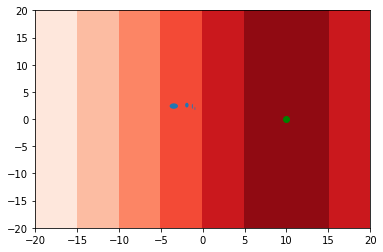

[-0.82250177  2.0480495 ] (10, 0)
(nan, 0.0)


/Users/libland/miniconda3/envs/scipy/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/libland/miniconda3/envs/scipy/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
mu, inter = run_cem(cem_iter, f1, d1, 0.1, 100, 100)
plot_intermeds(inter, f1,minima=minima1)
print(mu, minima1)
print(test_cem(cem_iter, f1, d1, 0.1, 100, minima1))

## Quadratic Function

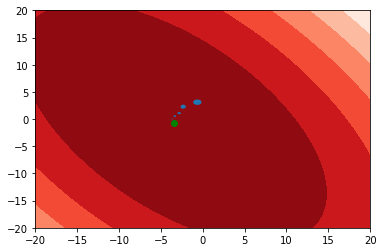

[-3.5968175  -0.49700499] [[-3.46462298 -0.77106068]]
(2.0, 0.1)


In [14]:
mu, inter = run_cem(cem_iter, f2, d2, 0.1, 100, 100)
plot_intermeds(inter, f2, minima=minima2)
print(mu, minima2)
print(test_cem(cem_iter, f2, d2, 0.1, 100, minima2))

## Rosenbrock

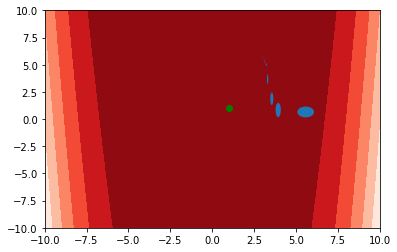

[2.97324101 5.9844479 ] (1, 1)
(nan, 0.0)


/Users/libland/miniconda3/envs/scipy/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/libland/miniconda3/envs/scipy/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
mu, inter = run_cem(cem_iter, f3, d3, 0.1, 100, 100)
plot_intermeds(inter, f3, minima=minima3, x_lim=(-10,10), y_lim=(-10,10))
print(mu, minima3)
print(test_cem(cem_iter, f3, d3, 0.1, 100, minima3))

# Noisy CEM

## Linear function

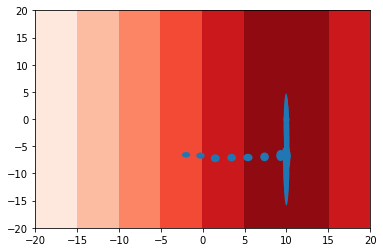

[10.00028961 -0.86839029] (10, 0)
(124.94444444444444, 0.6)


In [16]:
mu, inter = run_cem(noisy_cem_iter, f1, d1, 0.1, 100, 100)
plot_intermeds(inter, f1, minima=(10,0))
print(mu, minima1)
print(test_cem(noisy_cem_iter, f1, d1, 0.1, 100, minima1))

## Quadratic function

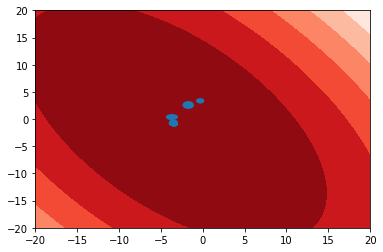

[-3.46771754 -0.77167942] [[-3.46462298 -0.77106068]]
(4.966666666666667, 1.0)


In [17]:
mu, inter = run_cem(noisy_cem_iter, f2, d1, 0.1, 100, 100)
plot_intermeds(inter, f2, minima=B)
print(mu, minima2)
print(test_cem(noisy_cem_iter, f2, d2, 0.1, 100, minima2))

## Rosenbrock

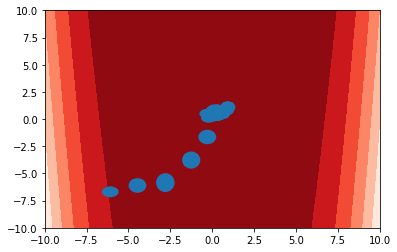

[0.82829833 0.68449703] (1, 1)
(452.7, 1.0)


In [18]:
mu, inter = run_cem(noisy_cem_iter, f3, d3, 0.1, 100, 100)
plot_intermeds(inter, f3, minima=minima3, x_lim=(-10,10), y_lim=(-10,10))
print(mu, minima3)
print(test_cem(noisy_cem_iter, f3, d3, 0.1, 100, minima3))

# Cauchy CEM

## Linear function

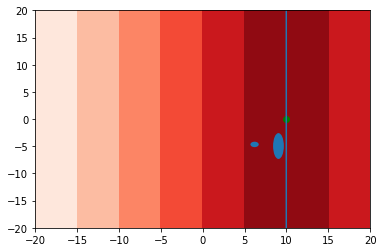

[1.00000124e+01 1.14751356e+04] (10, 0)
(1000.0, 0.0)


In [19]:
mu, inter = run_cem(cem_cauchy_iter, f1, d1, 0.1, 100, 100)
plot_intermeds(inter, f1,minima=minima1)
print(mu, minima1)
print(test_cem(cem_cauchy_iter, f1, d1, 0.1, 100, minima1))

## Quadratic Function

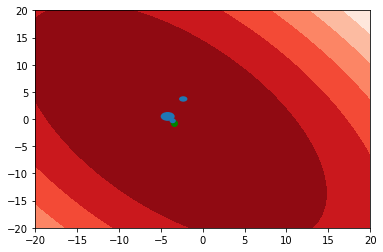

[-3.46462298 -0.77106068] [[-3.46462298 -0.77106068]]
(3.7666666666666666, 1.0)


In [20]:
mu, inter = run_cem(cem_cauchy_iter, f2, d2, 0.1, 100, 100)
plot_intermeds(inter, f2, minima=minima2)
print(mu, minima2)
print(test_cem(cem_cauchy_iter, f2, d2, 0.1, 100, minima2))

## Rosenbrock

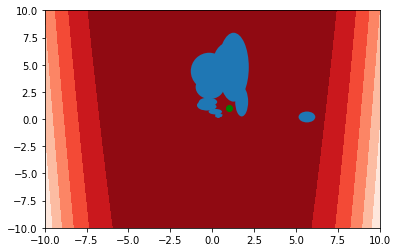

[0.78416834 0.61420459] (1, 1)
(430.6, 1.0)


In [21]:
mu, inter = run_cem(cem_cauchy_iter, f3, d3, 0.1, 100, 100)
plot_intermeds(inter, f3, minima=minima3, x_lim=(-10,10), y_lim=(-10,10))
print(mu, minima3)
print(test_cem(cem_cauchy_iter, f3, d3, 0.1, 100, minima3))

# Non-diagonal cauchy CEM

## Linear function

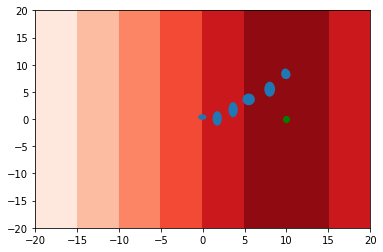

[10.00008242  7.83195341] (10, 0)
(16.25, 0.13333333333333333)


In [22]:
mu, inter = run_cem(noisy_cem_no_diag_iter, f1, d1, 0.1, 100, 100)
plot_intermeds(inter, f1,minima=minima1)
print(mu, minima1)
print(test_cem(noisy_cem_no_diag_iter, f1, d1, 0.1, 100, minima1))

## Quadratic Function

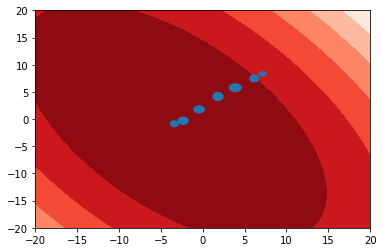

[-3.45254556 -0.78917492] [[-3.46462298 -0.77106068]]
(3.1666666666666665, 0.2)


In [23]:
mu, inter = run_cem(noisy_cem_no_diag_iter, f2, d2, 0.1, 100, 100)
plot_intermeds(inter, f2, minima=minima2)
print(mu, minima2)
print(test_cem(noisy_cem_no_diag_iter, f2, d2, 0.1, 100, minima2))

## Rosenbrock

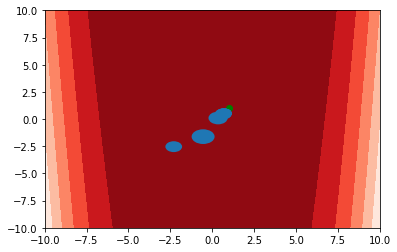

[0.68917505 0.46722679] (1, 1)
(6.5, 0.06666666666666667)


In [24]:
mu, inter = run_cem(noisy_cem_no_diag_iter, f3, d3, 0.1, 100, 100)
plot_intermeds(inter, f3, minima=minima3, x_lim=(-10,10), y_lim=(-10,10))
print(mu, minima3)
print(test_cem(noisy_cem_no_diag_iter, f3, d3, 0.1, 100, minima3))